In [1]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
import nltk
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
import statistics 
import matplotlib.pyplot as plt
from scipy import stats


In [33]:
dataset = pd.read_csv('datasets/imdb.csv')
dataset.head()
dataset = dataset[:1000]

In [34]:
# removeMostUsed tells if words used more than the provided percentage should be removed.
# if false, words used less then the percentage should be removed
def removeWords(tmpDataSet, removeMostUsed=True, percentage=0.5):
    numberEntries = len(tmpDataSet)
    neededAmount = numberEntries * percentage
    
    removeWords = {}
    for text in tmpDataSet:
        thisremoveWords = {}
        for word in text:
            if (word not in thisremoveWords):
                thisremoveWords[word]=1
                if (word not in removeWords):
                    removeWords[word]=1
                else:
                    removeWords[word]+=1
    # accedp only words used the needed amount or less
    if (removeMostUsed == True):
        removeWords = dict((k, v) for k, v in removeWords.items() if v >= neededAmount)
    # accedp only words used the needed amount or more
    else:
        removeWords = dict((k, v) for k, v in removeWords.items() if v <= neededAmount)
    newtmpDataSet = []
    for text in tmpDataSet:
        cleaned_list = [word for word in text if word not in removeWords]
        newtmpDataSet.append(cleaned_list)

    return (newtmpDataSet) 

In [41]:
def runMultipleTimes(dataset):
    f = open("w2v.txt", "w")
    percentageAndMostused = [[True, 1.0], [True, .9], [True, .8], [True, .7], [False, .3], [False, .2], [False, .1]]

    avgScores = []
    allScores = []
    sdScores = []
    avgF1Scores = []
    sdF1Scoress = []
    allF1Scores = []
    allLoss = []
    for elem in percentageAndMostused:
        X = [sent for sent in dataset['review']]
        X = [simple_preprocess(sent, deacc=True) for sent in X]
        X1 = removeWords(X, removeMostUsed=elem[0], percentage=elem[1])

        model = Word2Vec(X1, min_count=1, size=300, window=10)
       
        avgScore = 0
        avgF1Score = 0
        count = 30
        scores = []
        f1scores = []
        loss = []
        print(elem)
        for x in range(count):
            X_train, X_test, y_train, y_test = train_test_split(X1, dataset['sentiment'], test_size=0.33)
            
            (model.train(X1, total_examples=len(X), epochs=30))
            X_train_v = []
            for sent in X_train:
                sent_vector = np.mean([model.wv[word] for word in sent if word in model.wv], axis=0)
                X_train_v.append(sent_vector)                
            X_test_v = []
            for sent in X_test:
                sent_vector = np.mean([model.wv[word] for word in sent if word in model.wv], axis=0)
                X_test_v.append(sent_vector)
            mlp = MLPClassifier(max_iter=300)
            (mlp.fit(X_train_v, y_train))
            scores.append(mlp.score(X_test_v, y_test))
            y_pred = mlp.predict(X_test_v)
            f1scores.append(f1_score(y_test, y_pred, average='weighted'))
            loss.append(mlp.loss_)

        avgScore = statistics.mean(scores)
        allScores.append(scores)
        avgF1Score = statistics.mean(f1scores)
        allF1Scores.append(f1scores)

        sdScore = statistics.stdev(scores)
        sdF1Score = statistics.stdev(scores)

        avgScores.append(avgScore)
        avgF1Scores.append(avgF1Score)
        sdScores.append(sdScore)
        sdF1Scoress.append(sdF1Score)

        allLoss.append(loss)
        avgLoss = statistics.mean(loss)
        sdLoss = statistics.stdev(loss)
        print(avgScore,avgF1Score,avgLoss)


        f.write("most used: " + str(elem[0]) + '\n')
        f.write("rate " + str(elem[1]) + '\n\n')

        f.write("Average Score " + str(avgScore) + '\n')
        f.write("Score sd " + str(sdScore) + '\n')
        f.write("All Scores" + str(scores) + '\n\n')

        f.write("Average Loss " + str(avgLoss) + '\n')
        f.write("Loss sd " + str(sdLoss) + '\n')
        f.write("All losses" + str(loss) + '\n\n')

        f.write("Average F1Score " + str(avgF1Score) + '\n')
        f.write("F1Score sd " + str(sdF1Score) + '\n')
        f.write("All F1 Scores" + str(f1scores) + '\n\n\n')

    figScore, axScore = plt.subplots()
    axScore.set_title('Scores')
    axScore.boxplot(allScores)
    legend = ["All Words", "rm 90% most used", "rm 80% most used", "rm 70% most used", "rm 30% least usesd", "rm 20% least usesd", "rm 10% least usesd"]

    xTicks = []
    for i in range(1, len(avgScores)+1):
        xTicks.append(i)
    x = xTicks
    plt.xticks(x, legend, rotation=45)
    plt.title('Scores')
    plt.show()
    
    figF1Score, axF1Score = plt.subplots()
    axF1Score.set_title('F1 Scores')
    axF1Score.boxplot(allF1Scores)
    
    plt.xticks(x, legend, rotation=45)
    plt.title('F1 Scores')
    plt.show()
    
    figLoss, axLoss = plt.subplots()
    axLoss.set_title('Losses')
    axLoss.boxplot(allLoss)
    plt.xticks(x, legend, rotation=45)
    plt.title('Loss')
    plt.show()



In [43]:
def runWindowAndMinCount(dataset):
    f = open("w2v.txt", "w")
    scoresF = open("pvalues/w2vWindowMinCount/scores.txt", "w")
    f1scoresF = open("pvalues/w2vWindowMinCount/f1Scores.txt", "w")
    lossF = open("pvalues/w2vWindowMinCount/loss.txt", "w")

    minCountAndWindow = []
    for minCount in range (1, 6):
        for window in range (5, 11):
            minCountAndWindow.append([minCount, window])

    avgScores = []
    allScores = []
    sdScores = []
    avgF1Scores = []
    sdF1Scoress = []
    allF1Scores = []
    allLoss = []
    X = [remove_stopwords(sent)  for sent in dataset['review']]
    X = [simple_preprocess(sent, deacc=True) for sent in X]
    for elem in minCountAndWindow:

        model = Word2Vec(X, min_count=elem[0], size=300, window=elem[1])
       
        avgScore = 0
        avgF1Score = 0
        count = 30
        scores = []
        f1scores = []
        loss = []
        print(elem)
        for x in range(count):
            X_train, X_test, y_train, y_test = train_test_split(X, dataset['sentiment'], test_size=0.33)
            
            (model.train(X, total_examples=len(X), epochs=30))
            X_train_v = []
            for sent in X_train:
                sent_vector = np.mean([model.wv[word] for word in sent if word in model.wv], axis=0)
                X_train_v.append(sent_vector)                
            X_test_v = []
            for sent in X_test:
                sent_vector = np.mean([model.wv[word] for word in sent if word in model.wv], axis=0)
                X_test_v.append(sent_vector)
            mlp = MLPClassifier(max_iter=300)
            (mlp.fit(X_train_v, y_train))
            scores.append(mlp.score(X_test_v, y_test))
            y_pred = mlp.predict(X_test_v)
            f1scores.append(f1_score(y_test, y_pred, average='weighted'))
            loss.append(mlp.loss_)

        avgScore = statistics.mean(scores)
        allScores.append(scores)
        avgF1Score = statistics.mean(f1scores)
        allF1Scores.append(f1scores)

        sdScore = statistics.stdev(scores)
        sdF1Score = statistics.stdev(scores)

        avgScores.append(avgScore)
        avgF1Scores.append(avgF1Score)
        sdScores.append(sdScore)
        sdF1Scoress.append(sdF1Score)

        allLoss.append(loss)
        avgLoss = statistics.mean(loss)
        sdLoss = statistics.stdev(loss)
        print(avgScore,avgF1Score,avgLoss)

        scoresF.write(str(scores)+'\n')
        lossF.write(str(loss)+'\n')
        f1scoresF.write(str(f1scores)+'\n')

        f.write("min_count: " + str(elem[0]) + '\n')
        f.write("window: " + str(elem[1]) + '\n\n')

        f.write("Average Score " + str(avgScore) + '\n')
        f.write("Score sd " + str(sdScore) + '\n')
        f.write("All Scores" + str(scores) + '\n\n')

        f.write("Average Loss " + str(avgLoss) + '\n')
        f.write("Loss sd " + str(sdLoss) + '\n')
        f.write("All losses" + str(loss) + '\n\n')

        f.write("Average F1Score " + str(avgF1Score) + '\n')
        f.write("F1Score sd " + str(sdF1Score) + '\n')
        f.write("All F1 Scores" + str(f1scores) + '\n\n\n')

    figScore, axScore = plt.subplots()
    axScore.set_title('Scores')
    axScore.boxplot(allScores)
    legend = ["All Words", "rm 90% most used", "rm 80% most used", "rm 70% most used", "rm 30% least usesd", "rm 20% least usesd", "rm 10% least usesd"]

    xTicks = []
    for i in range(1, len(avgScores)+1):
        xTicks.append(i)
    x = xTicks
    plt.xticks(x, minCountAndWindow, rotation=90)
    plt.title('Scores')
    # plt.show()
    outfile = 'scores' + '.pdf'
    plt.savefig(outfile, dpi=500, bbox_inches='tight')
    
    figF1Score, axF1Score = plt.subplots()
    axF1Score.set_title('F1 Scores')
    axF1Score.boxplot(allF1Scores)
    
    plt.xticks(x, minCountAndWindow, rotation=90)
    plt.title('F1 Scores')
    # plt.show()
    outfile = 'f1Scores' + '.pdf'
    plt.savefig(outfile, dpi=500, bbox_inches='tight')
    
    figLoss, axLoss = plt.subplots()
    axLoss.set_title('Losses')
    axLoss.boxplot(allLoss)
    plt.xticks(x, minCountAndWindow, rotation=90)
    plt.title('Loss')
    # plt.show()
    outfile = 'loss' + '.pdf'
    plt.savefig(outfile, dpi=500, bbox_inches='tight')



In [37]:
# runMultipleTimes(dataset)

[1, 5]
0.79 0.7898652428842023 0.023357552906244264
[1, 6]
0.787979797979798 0.7878994881752774 0.021547526837827614
[1, 7]
0.7962626262626262 0.7962029841344931 0.02019289826593267
[1, 8]
0.797979797979798 0.7979759336501161 0.01851184361149562
[1, 9]
0.7955555555555556 0.7954630456711906 0.017196496943058522
[1, 10]
0.8023232323232323 0.8022368278619669 0.017754838284939616
[2, 5]
0.7902020202020202 0.7901686899831786 0.019877718596402687
[2, 6]
0.7941414141414141 0.7941486823735976 0.017859970597576505
[2, 7]
0.7863636363636364 0.7863154113965032 0.017181710724384392
[2, 8]
0.7933333333333333 0.7932768459142904 0.016365484947254046
[2, 9]
0.803030303030303 0.8029297668492593 0.01539537603854692
[2, 10]
0.8033333333333333 0.8032418948421461 0.014501347611008625
[3, 5]
0.7935353535353535 0.7934522083969032 0.017380121378440097
[3, 6]
0.8072727272727273 0.8071197219275186 0.018070928867169718
[3, 7]
0.7936363636363637 0.7935971705291566 0.015873820745289004
[3, 8]
0.7993939393939394 0.

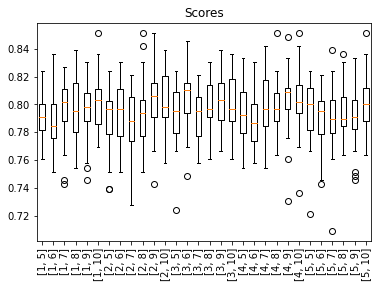

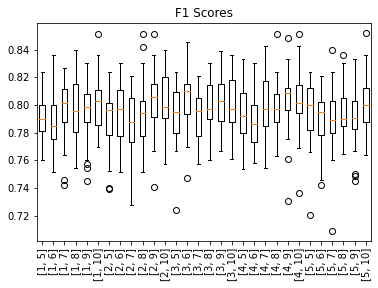

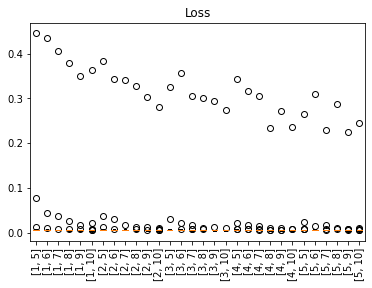

In [44]:
runWindowAndMinCount(dataset)

In [40]:
X = [remove_stopwords(sent)  for sent in dataset['review']]
X = [simple_preprocess(sent, deacc=True) for sent in X]
# X1 = removeWords(X, removeMostUsed=False, percentage=.9)
X_train, X_test, y_train, y_test = train_test_split(X, dataset['sentiment'], test_size=0.33)

In [41]:
model = Word2Vec(X, min_count=1, size=300, window=10)
model.train(X, total_examples=len(X), epochs=30)

(3429594, 3707430)

In [42]:
X_train_v = []
for sent in X_train:
    sent_vector = np.mean([model.wv[word] for word in sent if word in model.wv], axis=0)
    X_train_v.append(sent_vector)

    
X_test_v = []
for sent in X_test:
    sent_vector = np.mean([model.wv[word] for word in sent if word in model.wv], axis=0)
    X_test_v.append(sent_vector)


In [47]:
mlp = MLPClassifier(max_iter=300)
mlp.fit(X_train_v, y_train)

MLPClassifier(max_iter=300)

In [48]:
mlp.score(X_test_v, y_test)

0.7515151515151515

In [45]:

y_pred = mlp.predict(X_test_v)
f1_score(y_test, y_pred, average='weighted')

0.7455293870009589